### Stage 1: Motion Correction

In [1]:
# --- Init ---
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# наши модули
from hybrid.io.tif import read_tiff_memmap, write_tiff_stack  # ридер
from hybrid.cli.mc_cli import run_mc        # батч-PWrigid API из CLI (реэкспорт в __init__ тоже ок)
from hybrid.summary.qc_maps import correlation_image, pnr_image
from hybrid.filters.flatfield import estimate_flatfield, apply_flatfield  # :contentReference[oaicite:0]{index=0}

# === пути (относительно папки ноутбука D:\Projects\hybrid\notebooks) ===
DATA_DIR = Path("data/shorts")
BASENAME = "MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125"

# вход: .tif или .tiff (попробуем оба варианта)
in_path = None
for ext in (".tiff", ".tif"):
    p = (DATA_DIR / f"{BASENAME}{ext}")
    if p.exists():
        in_path = p
        break
assert in_path is not None, "Файл не найден ни с .tiff, ни с .tif"

# целевая папка (без clip-сегмента)
root_name = BASENAME.split("_clip_")[0]
OUT_DIR = DATA_DIR / root_name
OUT_DIR_QC = OUT_DIR / "_qc_mc"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR_QC.mkdir(parents=True, exist_ok=True)

print("Input:", in_path)
print("Out dir:", OUT_DIR)


Input: data\shorts\MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125.tiff
Out dir: data\shorts\MoS1b_s3_C1_M3_T3_TRE_2025_04_08


Loaded: (300, 800, 768) uint16


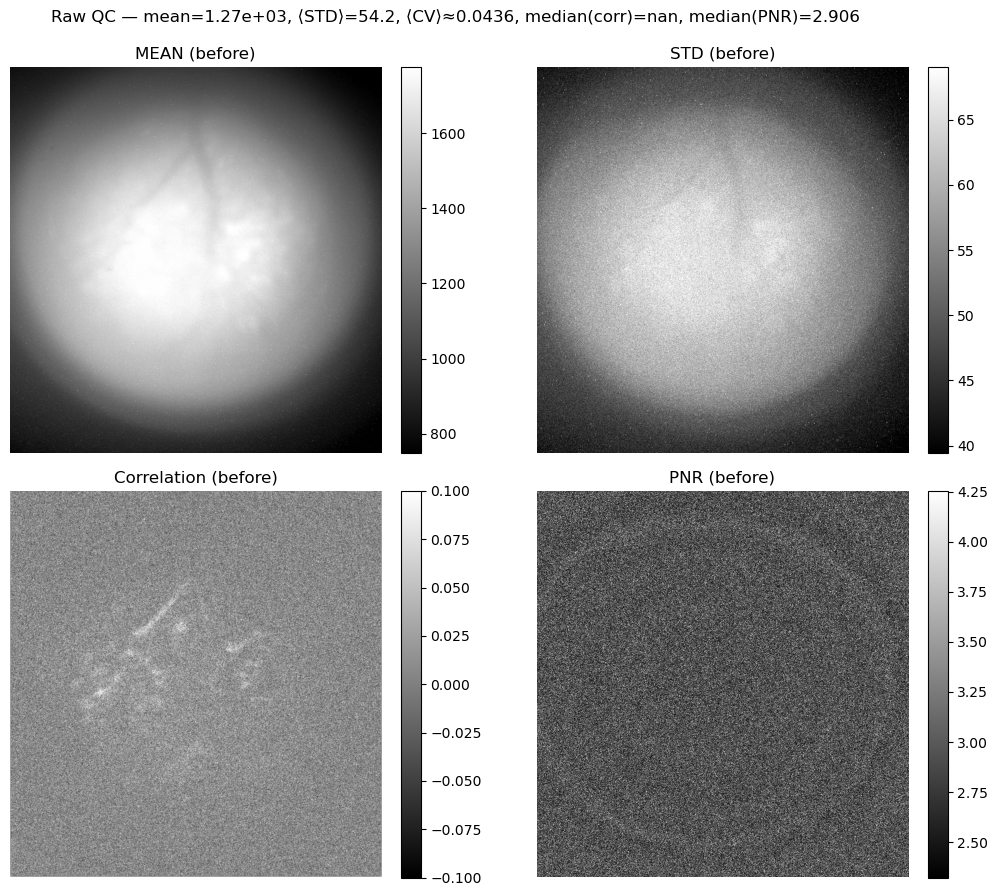

In [2]:
# --- QC BEFORE (raw) ---

# надёжная загрузка стека: пробуем memmap, иначе полный имрид
from hybrid.io.tif import read_tiff_memmap, read_tiff_stack
try:
    raw = read_tiff_memmap(in_path)                   # (T, H, W) если файл «правильный» стек
except Exception:
    raw = read_tiff_stack(in_path, method="auto",     # (T, H, W) float/uint
                          normalize_mode="none", verbose=False)

T, H, W = raw.shape
print("Loaded:", raw.shape, raw.dtype)

# базовые карты
raw_f32 = raw.astype(np.float32, copy=False)
mean_before = raw_f32.mean(axis=0)
std_before  = raw_f32.std(axis=0, ddof=1)

# карты qc_maps
corr_before = correlation_image(raw_f32, time_axis=0)          # (H, W) float32
pnr_before  = pnr_image(raw_f32, time_axis=0, hp_window=7)     # (H, W) float32

# числовые метрики для подписи
global_mean = float(mean_before.mean())
global_std  = float(std_before.mean())
cv_bg       = float((std_before / (mean_before + 1e-9)).mean())
corr_med    = float(np.median(corr_before))
pnr_med     = float(np.median(pnr_before))

# шкалы по перцентилям (сохраним, чтобы потом использовать те же для "после")
scales = {
    "mean": (float(np.percentile(mean_before, 1)),  float(np.percentile(mean_before, 99))),
    "std":  (float(np.percentile(std_before,  1)),  float(np.percentile(std_before,  99))),
    "corr": (float(np.percentile(corr_before, 5)),  float(np.percentile(corr_before, 95))),
    "pnr":  (float(np.percentile(pnr_before,  5)),  float(np.percentile(pnr_before,  99))),
}
np.save(OUT_DIR_QC / "scales_before.npy", scales)

# визуализация: mean / std / corr / pnr
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(11, 9))

im0 = axs[0,0].imshow(mean_before, cmap="gray", vmin=scales["mean"][0], vmax=scales["mean"][1])
axs[0,0].set_title("MEAN (before)"); axs[0,0].axis("off"); fig.colorbar(im0, ax=axs[0,0], fraction=0.046, pad=0.04)

im1 = axs[0,1].imshow(std_before,  cmap="gray", vmin=scales["std"][0],  vmax=scales["std"][1])
axs[0,1].set_title("STD (before)");  axs[0,1].axis("off"); fig.colorbar(im1, ax=axs[0,1], fraction=0.046, pad=0.04)

im2 = axs[1,0].imshow(corr_before, cmap="gray", vmin=scales["corr"][0], vmax=scales["corr"][1])
axs[1,0].set_title("Correlation (before)"); axs[1,0].axis("off"); fig.colorbar(im2, ax=axs[1,0], fraction=0.046, pad=0.04)

im3 = axs[1,1].imshow(pnr_before,  cmap="gray", vmin=scales["pnr"][0],  vmax=scales["pnr"][1])
axs[1,1].set_title("PNR (before)"); axs[1,1].axis("off"); fig.colorbar(im3, ax=axs[1,1], fraction=0.046, pad=0.04)

plt.suptitle(
    f"Raw QC — mean={global_mean:.3g}, ⟨STD⟩={global_std:.3g}, ⟨CV⟩≈{cv_bg:.3g}, "
    f"median(corr)={corr_med:.3f}, median(PNR)={pnr_med:.3f}",
    y=0.99
)
plt.tight_layout()
plt.savefig(OUT_DIR_QC / "mc_before_qc_grid.png", dpi=200, bbox_inches="tight")
plt.show()


Cropped shape: (300, 768, 768)
Masked stack: (300, 768, 768) float32
Saved: data\shorts\MoS1b_s3_C1_M3_T3_TRE_2025_04_08\MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125_crop768_masked.tiff


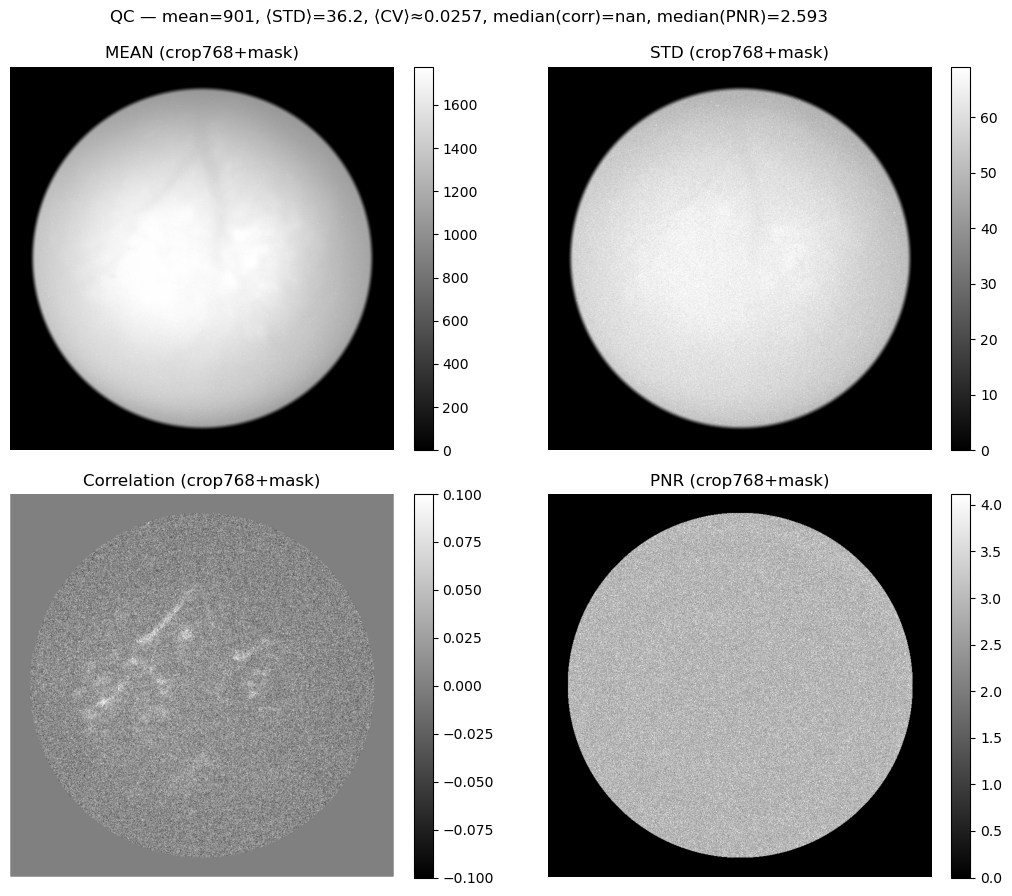

In [3]:
# --- CROP(768) + SOFT MASK + QC MAPS ---

# 0) берём исходный стек (если уже есть переменная raw, используем её)
try:
    raw
except NameError:
    try:
        raw = read_tiff_memmap(in_path)
    except Exception:
        raw = read_tiff_stack(in_path, method="auto", normalize_mode="none", verbose=False)

T, H, W = raw.shape
assert (H, W) == (800, 768), f"Ожидаю (800,768), а получил {raw.shape}"

# 1) обрезаем низ до квадрата 768×768
raw_crop = raw[:, :768, :]   # (T, 768, 768)
Tc, Hc, Wc = raw_crop.shape
print("Cropped shape:", raw_crop.shape)

# 2) мягкая круглая маска на 768×768
import numpy as np
cy = cx = Hc // 2                            # центр (384,384)
r  = int(0.9 * (Hc // 2))                   # радиус полезной области (~0.95*384)
edge = 12.0                                  # ширина мягкого края (px)

yy, xx = np.ogrid[:Hc, :Wc]
dist = np.sqrt((yy - cy)**2 + (xx - cx)**2)

mask = np.ones((Hc, Wc), np.float32)
mask[dist > r] = 0.0
ring = (dist > r - edge) & (dist <= r)
mask[ring] = 0.5 * (1.0 + np.cos(np.pi * (dist[ring] - (r - edge)) / edge))

# 3) применяем маску (обнуление вне области, плавный край)
masked = (raw_crop.astype(np.float32, copy=False)) * mask[None, ...]
print("Masked stack:", masked.shape, masked.dtype)

# 4) сохраняем стек
crop_mask_name = f"{BASENAME}_crop768_masked.tiff"
CROP_MASK_PATH = (OUT_DIR / crop_mask_name)
from hybrid.io.tif import write_tiff_stack
write_tiff_stack(CROP_MASK_PATH.as_posix(), masked, dtype="float32", bigtiff=False, compress=True)
print("Saved:", CROP_MASK_PATH)

# 5) QC maps: MEAN / STD / Correlation / PNR
mean_map = masked.mean(axis=0)
std_map  = masked.std(axis=0, ddof=1)
corr_map = correlation_image(masked, time_axis=0)
pnr_map  = pnr_image(masked, time_axis=0, hp_window=7)

# перцентильные шкалы (как в предыдущих ячейках)
scales = {
    "mean": (float(np.percentile(mean_map, 1)),  float(np.percentile(mean_map, 99))),
    "std":  (float(np.percentile(std_map,  1)),  float(np.percentile(std_map,  99))),
    "corr": (float(np.percentile(corr_map, 5)),  float(np.percentile(corr_map, 95))),
    "pnr":  (float(np.percentile(pnr_map,  5)),  float(np.percentile(pnr_map,  99))),
}

# 6) визуализация
fig, axs = plt.subplots(2, 2, figsize=(11, 9))

im0 = axs[0,0].imshow(mean_map, cmap="gray", vmin=scales["mean"][0], vmax=scales["mean"][1])
axs[0,0].set_title("MEAN (crop768+mask)"); axs[0,0].axis("off"); fig.colorbar(im0, ax=axs[0,0], fraction=0.046, pad=0.04)

im1 = axs[0,1].imshow(std_map,  cmap="gray", vmin=scales["std"][0],  vmax=scales["std"][1])
axs[0,1].set_title("STD (crop768+mask)");  axs[0,1].axis("off"); fig.colorbar(im1, ax=axs[0,1], fraction=0.046, pad=0.04)

im2 = axs[1,0].imshow(corr_map, cmap="gray", vmin=scales["corr"][0], vmax=scales["corr"][1])
axs[1,0].set_title("Correlation (crop768+mask)"); axs[1,0].axis("off"); fig.colorbar(im2, ax=axs[1,0], fraction=0.046, pad=0.04)

im3 = axs[1,1].imshow(pnr_map,  cmap="gray", vmin=scales["pnr"][0],  vmax=scales["pnr"][1])
axs[1,1].set_title("PNR (crop768+mask)"); axs[1,1].axis("off"); fig.colorbar(im3, ax=axs[1,1], fraction=0.046, pad=0.04)

gm, gs = float(mean_map.mean()), float(std_map.mean())
cv = float((std_map / (mean_map + 1e-9)).mean())
corr_med = float(np.median(corr_map)); pnr_med = float(np.median(pnr_map))
plt.suptitle(
    f"QC — mean={gm:.3g}, ⟨STD⟩={gs:.3g}, ⟨CV⟩≈{cv:.3g}, median(corr)={corr_med:.3f}, median(PNR)={pnr_med:.3f}",
    y=0.99
)
plt.tight_layout()
plt.savefig(OUT_DIR_QC / "crop768_masked_qc_grid.png", dpi=200, bbox_inches="tight")
plt.show()


Saved: MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125_crop768_masked_flatmap_reg.tiff | MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125_crop768_masked_flatfield_reg.tiff


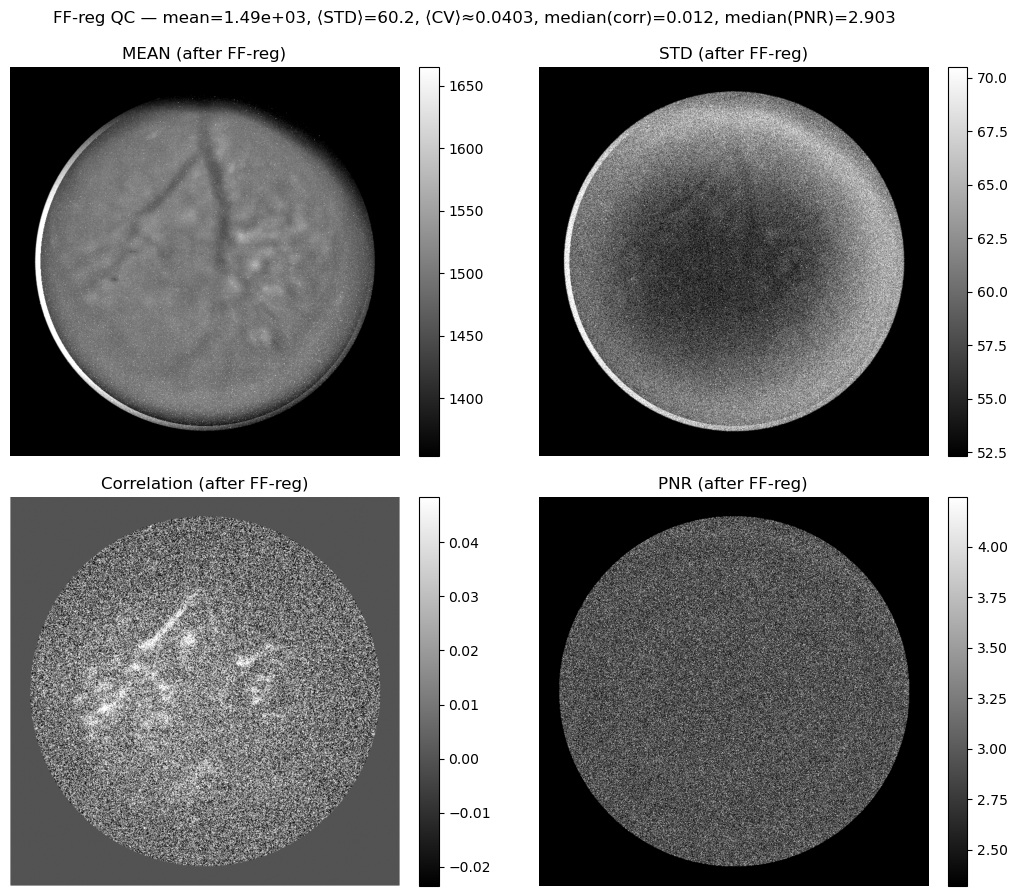

In [4]:
# --- FLAT-FIELD (estimate + apply) + SAVE + QC [pre-MC, fixed edges] ---

import numpy as np
from scipy.ndimage import gaussian_filter

# ===== параметры под pre-MC =====
sigma_px = 24.0          # подавляем шапку, но оставляем средние частоты
erode_px = 6             # сужаем ядро оценки поля, чтобы не «тянуть» край
floor_pct = 5.0          # нижний пол деления (перцентиль по ядру)
gain_cap = 1.7           # ОГРАНИЧЕНИЕ усиления: делим не сильнее чем ×1.7

# 0) источник: квадратный стек с мягкой маской
try:
    src = masked.astype(np.float32, copy=False)   # (T,768,768) после crop+mask
    Hc, Wc = src.shape[1:]
    base_mask = mask.astype(np.float32, copy=False)
except NameError:
    src = read_tiff_stack(OUT_DIR / f"{BASENAME}_crop768_masked.tiff",
                          method="auto", normalize_mode="none", verbose=False).astype(np.float32)
    T, Hc, Wc = src.shape
    # если маски нет в памяти — построим такую же мягкую
    cy = cx = Hc // 2
    r  = int(0.95 * (Hc // 2)); edge = 12.0
    yy, xx = np.ogrid[:Hc, :Wc]
    dist = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    base_mask = np.ones((Hc, Wc), np.float32)
    base_mask[dist > r] = 0.0
    ring = (dist > r - edge) & (dist <= r)
    base_mask[ring] = 0.5 * (1.0 + np.cos(np.pi * (dist[ring] - (r - edge)) / edge))

# 1) ядро для оценки поля (эрозированная ЖЁСТКАЯ маска)
cy = cx = Hc // 2
yy, xx = np.ogrid[:Hc, :Wc]
dist = np.sqrt((yy - cy)**2 + (xx - cx)**2)
# оценим радиус по уровню 0.5 исходной маски и сузим
r_est = np.percentile(dist[base_mask > 0.5], 95)
core_mask = (dist <= (r_est - erode_px)).astype(np.float32)

# 2) оценка flat (normalized blur по temporal median, только в ядре)
med = np.median(src, axis=0).astype(np.float32)
num = gaussian_filter(med * core_mask, sigma=sigma_px)
den = gaussian_filter(core_mask,     sigma=sigma_px) + 1e-6
flat = num / den
flat[core_mask == 0] = 1.0
flat /= (np.mean(flat[core_mask > 0]) + 1e-6)   # нормируем среднее поля к 1

# 3) безопасное деление: floor + GAIN CAP
floor = float(np.percentile(flat[core_mask > 0], floor_pct))
flat_safe = np.maximum(flat, floor).astype(np.float32)

# >>> вот здесь «gain cap» <<<
gain = 1.0 / flat_safe                   # что мы умножаем на кадры
gain = np.minimum(gain, gain_cap)        # ограничили усиление
# применяем только внутри мягкой маски
movie_ff = src * gain[None, ...]
movie_ff *= base_mask[None, ...]

# 4) сохранить карту и стек (вариант для регистрации)
FF_MAP_PATH = OUT_DIR / f"{BASENAME}_crop768_masked_flatmap_reg.tiff"
FF_MOV_PATH = OUT_DIR / f"{BASENAME}_crop768_masked_flatfield_reg.tiff"
write_tiff_stack(FF_MAP_PATH.as_posix(), flat_safe, dtype="float32", bigtiff=False, compress=True)
write_tiff_stack(FF_MOV_PATH.as_posix(), movie_ff.astype(np.float32), dtype="float32", bigtiff=False, compress=True)
print("Saved:", FF_MAP_PATH.name, "|", FF_MOV_PATH.name)

# 5) QC внутри маски
core = base_mask > 0.99
mean_ff = movie_ff.mean(axis=0); std_ff = movie_ff.std(axis=0, ddof=1)
corr_ff = correlation_image(movie_ff, time_axis=0)
pnr_ff  = pnr_image(movie_ff, time_axis=0, hp_window=7)

vmean = (float(np.nanpercentile(mean_ff[core], 1)),  float(np.nanpercentile(mean_ff[core], 99)))
vstd  = (float(np.nanpercentile(std_ff[core],  1)),  float(np.nanpercentile(std_ff[core],  99)))
vcorr = (float(np.nanpercentile(corr_ff[core], 5)),  float(np.nanpercentile(corr_ff[core], 95)))
vpnr  = (float(np.nanpercentile(pnr_ff[core],  5)),  float(np.nanpercentile(pnr_ff[core],  99)))

fig, axs = plt.subplots(2, 2, figsize=(11, 9))
im0 = axs[0,0].imshow(mean_ff, cmap="gray", vmin=vmean[0], vmax=vmean[1]); axs[0,0].set_title("MEAN (after FF-reg)"); axs[0,0].axis("off"); fig.colorbar(im0, ax=axs[0,0], fraction=0.046, pad=0.04)
im1 = axs[0,1].imshow(std_ff,  cmap="gray", vmin=vstd[0],  vmax=vstd[1]);  axs[0,1].set_title("STD (after FF-reg)");  axs[0,1].axis("off"); fig.colorbar(im1, ax=axs[0,1], fraction=0.046, pad=0.04)
im2 = axs[1,0].imshow(corr_ff, cmap="gray", vmin=vcorr[0], vmax=vcorr[1]); axs[1,0].set_title("Correlation (after FF-reg)"); axs[1,0].axis("off"); fig.colorbar(im2, ax=axs[1,0], fraction=0.046, pad=0.04)
im3 = axs[1,1].imshow(pnr_ff,  cmap="gray", vmin=vpnr[0],  vmax=vpnr[1]);  axs[1,1].set_title("PNR (after FF-reg)");  axs[1,1].axis("off"); fig.colorbar(im3, ax=axs[1,1], fraction=0.046, pad=0.04)

gm = float(np.nanmean(mean_ff[core])); gs = float(np.nanmean(std_ff[core]))
cv = float(np.nanmean(std_ff[core] / (mean_ff[core] + 1e-9)))
corr_med = float(np.nanmedian(corr_ff[core])); pnr_med = float(np.nanmedian(pnr_ff[core]))
plt.suptitle(f"FF-reg QC — mean={gm:.3g}, ⟨STD⟩={gs:.3g}, ⟨CV⟩≈{cv:.3g}, median(corr)={corr_med:.3f}, median(PNR)={pnr_med:.3f}", y=0.99)
plt.tight_layout(); plt.savefig(OUT_DIR_QC / "flatfield_reg_qc_grid.png", dpi=200, bbox_inches="tight"); plt.show()


### Translation detection v_1

In [5]:
from pathlib import Path
from hybrid.io.tif import read_tiff_stack  # тот, что мы чинили

in_path = Path("data/shorts/MoS1b_s3_C1_M3_T3_TRE_2025_04_08/MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125_crop768_masked_flatfield_reg.tiff")
movie = read_tiff_stack(in_path, method="auto", verbose=True).astype("float32")  # shape: (T,H,W)


[I/O] Using full-RAM imread (~0.66 GiB): D:\Projects\hybrid\notebooks\data\shorts\MoS1b_s3_C1_M3_T3_TRE_2025_04_08\MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125_crop768_masked_flatfield_reg.tiff


In [6]:
import numpy as np
from scipy.ndimage import gaussian_filter

def ncc(a,b):
    a = a - a.mean(); b = b - b.mean()
    den = (a.std()+1e-6)*(b.std()+1e-6)
    return float((a*b).sum()/den)

def estimate_shift_roi(A, B, cy, cx, hw=32, search=12, pre_smooth=0.0):
    """Возвращает (dy, dx) B->A в пикселях; сначала integer в окне поиска, потом субпиксель по параболе."""
    A = A.astype(np.float32); B = B.astype(np.float32)
    if pre_smooth>0:
        A = gaussian_filter(A, pre_smooth); B = gaussian_filter(B, pre_smooth)
    A = A[cy-hw:cy+hw+1, cx-hw:cx+hw+1]  # (2*hw+1)^2
    best = (-1e9, 0, 0)
    for dy in range(-search, search+1):
        for dx in range(-search, search+1):
            Bb = B[cy-hw+dy:cy+hw+1+dy, cx-hw+dx:cx+hw+1+dx]
            if Bb.shape != A.shape: 
                continue
            s = ncc(A, Bb)
            if s > best[0]:
                best = (s, dy, dx)
    peak, iy, ix = best
    # субпиксель: парабола по 3 точкам отдельно по y и x (если есть соседи)
    def subpix_1d(score_m1, score_0, score_p1):
        denom = (score_m1 - 2*score_0 + score_p1) + 1e-12
        return 0.5*(score_m1 - score_p1)/denom
    # y
    s_m1 = ncc(A, B[cy-hw+iy-1:cy+hw+1+iy-1, cx-hw+ix:cx+hw+1+ix]) if abs(iy-1) <= search else peak
    s_p1 = ncc(A, B[cy-hw+iy+1:cy+hw+1+iy+1, cx-hw+ix:cx+hw+1+ix]) if abs(iy+1) <= search else peak
    dy_sub = iy + subpix_1d(s_m1, peak, s_p1)
    # x
    s_m1 = ncc(A, B[cy-hw+iy:cy+hw+1+iy, cx-hw+ix-1:cx+hw+1+ix-1]) if abs(ix-1) <= search else peak
    s_p1 = ncc(A, B[cy-hw+iy:cy+hw+1+iy, cx-hw+ix+1:cx+hw+1+ix+1]) if abs(ix+1) <= search else peak
    dx_sub = ix + subpix_1d(s_m1, peak, s_p1)
    return float(dy_sub), float(dx_sub), float(peak)


In [7]:
dy, dx, score = estimate_shift_roi(movie[25], movie[32], cy=192 , cx=383 , hw=32, search=6, pre_smooth=1.0)
print(dy, dx, score)


-6.500000000000009 3.9199553419736892 2294.841064453125


In [8]:
lstx = []
lsty = []
for i in range(25, 31):
    dy, dx, score = estimate_shift_roi(movie[i], movie[i+1], cy=192 , cx=383 , hw=32, search=6, pre_smooth=1.0)
    print(dy, dx, score)
    lstx.append(dx)
    lsty.append(dy)
print('Sum X: ', sum(lstx))
print('Sum Y: ', sum(lsty))

dy, dx, score = estimate_shift_roi(movie[25], movie[32], cy=192 , cx=383 , hw=32, search=6, pre_smooth=1.0)
print('Total ', dy, dx, score)
print('Difference X: ', dx-sum(lstx), '\nDifference Y: ', dy-sum(lsty))

-0.6648825937996099 3.036569406195235 2574.468017578125
-4.134581224653957 0.6826917798371357 2427.1796875
0.9929852736197802 -0.055793554450406194 2515.19287109375
-0.13518023615862176 -0.3422784045559538 2436.17626953125
1.9736842105263146 0.23719272662754312 2422.947998046875
-3.877173354548916 2.8118382028404394 2386.669921875
Sum X:  6.370220156493993
Sum Y:  -5.845147925015009
Total  -6.500000000000009 3.9199553419736892 2294.841064453125
Difference X:  -2.4502648145203034 
Difference Y:  -0.6548520749849995


### Translation detection + rotetion detection v_2

In [9]:
import numpy as np
from scipy.ndimage import gaussian_filter, shift as imshift, rotate as imrotate

# ----- базовые утилиты -----
def ncc(a, b):
    a = a - a.mean(); b = b - b.mean()
    den = (a.std()+1e-6) * (b.std()+1e-6)
    return float((a*b).sum() / den)

def cos_window(h, w):
    """2D косиновое окно (аподизация), снижает влияние краёв при повороте."""
    wy = 0.5 - 0.5 * np.cos(2*np.pi*np.arange(h)/(h-1))
    wx = 0.5 - 0.5 * np.cos(2*np.pi*np.arange(w)/(w-1))
    return np.outer(wy, wx).astype(np.float32)

def subparabola(m1, m0, p1):
    """Параболическая подстройка вершины по трём точкам (-1,0,+1). Возвращает смещение вершины в шагах."""
    denom = (m1 - 2*m0 + p1) + 1e-12
    return 0.5 * (m1 - p1) / denom

# ----- твой этап: translation -----
def estimate_shift_roi(A, B, cy, cx, hw=32, search=12, pre_smooth=0.0):
    """Возвращает (dy, dx, peak) B->A в пикселях (dy<0 вверх, dx>0 вправо)."""
    A = A.astype(np.float32); B = B.astype(np.float32)
    if pre_smooth > 0:
        A = gaussian_filter(A, pre_smooth); B = gaussian_filter(B, pre_smooth)

    Aroi = A[cy-hw:cy+hw+1, cx-hw:cx+hw+1]
    best = (-1e9, 0, 0)
    for dy in range(-search, search+1):
        for dx in range(-search, search+1):
            Broi = B[cy-hw+dy:cy+hw+1+dy, cx-hw+dx:cx+hw+1+dx]
            if Broi.shape != Aroi.shape:
                continue
            s = ncc(Aroi, Broi)
            if s > best[0]:
                best = (s, dy, dx)
    peak, iy, ix = best

    # субпиксель по y
    s_m1 = ncc(Aroi, B[cy-hw+iy-1:cy+hw+1+iy-1, cx-hw+ix:cx+hw+1+ix]) if abs(iy-1) <= search else peak
    s_p1 = ncc(Aroi, B[cy-hw+iy+1:cy+hw+1+iy+1, cx-hw+ix:cx+hw+1+ix]) if abs(iy+1) <= search else peak
    dy_sub = iy + subparabola(s_m1, peak, s_p1)

    # субпиксель по x
    s_m1 = ncc(Aroi, B[cy-hw+iy:cy+hw+1+iy, cx-hw+ix-1:cx+hw+1+ix-1]) if abs(ix-1) <= search else peak
    s_p1 = ncc(Aroi, B[cy-hw+iy:cy+hw+1+iy, cx-hw+ix+1:cx+hw+1+ix+1]) if abs(ix+1) <= search else peak
    dx_sub = ix + subparabola(s_m1, peak, s_p1)

    return float(dy_sub), float(dx_sub), float(peak)

# ----- новый этап: малый поворот вокруг центра ROI -----
def estimate_rotation_roi(A, B, cy, cx, dy, dx, hw=32, theta_max=5.0, theta_step=0.5, pre_smooth=0.0, use_window=True):
    """
    Ищем угол поворота (в градусах) кадра B относительно A внутри ROI.
    A, B — исходные кадры; (cy, cx) — центр ROI в A; (dy, dx) — уже найденный сдвиг B->A.
    Сначала сдвигаем B на (dy,dx), затем перебираем углы в диапазоне [-theta_max, +theta_max].
    """
    A = A.astype(np.float32); B = B.astype(np.float32)
    if pre_smooth > 0:
        A = gaussian_filter(A, pre_smooth); B = gaussian_filter(B, pre_smooth)

    # вырезаем ROI из A
    Aroi = A[cy-hw:cy+hw+1, cx-hw:cx+hw+1]
    # сдвигаем весь B, затем берём тот же ROI-окно
    Bshift = imshift(B, shift=(-dy, -dx), order=1, mode='nearest', prefilter=False)
    Broi = Bshift[cy-hw:cy+hw+1, cx-hw:cx+hw+1]

    # аподизация краёв (уменьшает артефакты при повороте)
    if use_window:
        w = cos_window(*Aroi.shape)
        Aroi_w = Aroi * w
    else:
        w = 1.0
        Aroi_w = Aroi

    # грубый поиск по углам
    thetas = np.arange(-theta_max, theta_max + 1e-6, theta_step, dtype=np.float32)
    scores = []
    best = (-1e9, 0.0)
    for th in thetas:
        R = imrotate(Broi, angle=th, reshape=False, order=1, mode='nearest', prefilter=False)
        s = ncc(Aroi_w, (R * w) if use_window else R)
        scores.append(s)
        if s > best[0]:
            best = (s, th)
    peak_rot, th0 = best

    # суб-градусная подстройка параболой по соседним отсчётам
    i0 = int(round((th0 - thetas[0]) / theta_step))
    if 0 < i0 < len(thetas)-1:
        m1, m0, p1 = scores[i0-1], scores[i0], scores[i0+1]
        delta = subparabola(m1, m0, p1) * theta_step
        th_sub = th0 + float(delta)
    else:
        th_sub = th0

    return float(th_sub), float(peak_rot)

# ----- объединяющая обёртка -----
def estimate_shift_rot_roi(A, B, cy, cx, hw=32,
                           search=12, pre_smooth=0.0,
                           theta_max=5.0, theta_step=0.5, use_window=True):
    """
    Возвращает: dy, dx (пикс), theta_deg (градусы), score_trans, score_rot.
    """
    dy, dx, peak_t = estimate_shift_roi(A, B, cy, cx, hw=hw, search=search, pre_smooth=pre_smooth)
    theta_deg, peak_r = estimate_rotation_roi(A, B, cy, cx, dy, dx, hw=hw,
                                              theta_max=theta_max, theta_step=theta_step,
                                              pre_smooth=pre_smooth, use_window=use_window)
    return dy, dx, theta_deg, peak_t, peak_r


In [10]:
# пример: один ROI в (cy,cx) = (192,383)
dy, dx, theta_deg, s_t, s_r = estimate_shift_rot_roi(movie[25], movie[32],
                                                     cy=192, cx=383,
                                                     hw=32, search=12,
                                                     pre_smooth=1.0,
                                                     theta_max=5.0, theta_step=0.5)
print(f"dy={dy:.2f}, dx={dx:.2f}, θ={theta_deg:.2f}° | trans={s_t:.3f}, rot={s_r:.3f}")


dy=-10.13, dx=4.43, θ=2.62° | trans=2432.938, rot=4224.072


### ROI detection + translation detection + rotetion detection v_3

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter, sobel, uniform_filter, distance_transform_edt
from skimage.feature import corner_shi_tomasi, peak_local_max

# --- utility: min–max нормализация с безопасным делением ---
def _norm01(x):
    x = x.astype(np.float32)
    mn, mx = np.percentile(x, 1), np.percentile(x, 99)  # робастно
    return np.clip((x - mn) / (mx - mn + 1e-6), 0, 1)

def build_info_map(frame, sigma_smooth=1.0, std_win=11,
                   w_grad=0.4, w_corner=0.4, w_std=0.2):
    """Собираем карту информативности S из градиента, углов и локальной STD."""
    f = gaussian_filter(frame.astype(np.float32), sigma_smooth)

    # модуль градиента
    gy = sobel(f, axis=0); gx = sobel(f, axis=1)
    grad = np.hypot(gx, gy)

    # угловатость Shi–Tomasi
    corner = corner_shi_tomasi(f)

    # локальная дисперсия (STD через mean и mean of squares)
    mu  = uniform_filter(f, std_win)
    mu2 = uniform_filter(f**2, std_win)
    std = np.sqrt(np.maximum(mu2 - mu**2, 0))

    # нормируем и смешиваем
    G = _norm01(grad); C = _norm01(corner); V = _norm01(std)
    S = w_grad*G + w_corner*C + w_std*V
    return S, {'grad':G, 'corner':C, 'std':V}

def select_rois(frame_ref, mask, K=10, hw=32, search=6, margin=12,
                sigma_smooth=1.0, std_win=11,
                w_grad=0.4, w_corner=0.4, w_std=0.2,
                min_distance_factor=2.0):
    """
    Возвращает centers [(y,x), ...], карту S и валидную область.
    - mask: 1 внутри диска, 0 снаружи (может быть мягкой – возьмём >0.5)
    - ROI-центры не ближе чем (hw+search+margin) к маске и друг к другу.
    """
    H, W = frame_ref.shape
    # информативность
    S, parts = build_info_map(frame_ref, sigma_smooth, std_win, w_grad, w_corner, w_std)

    # валидная внутренняя область (дистанция до края маски)
    core_bin = (mask > 0.5).astype(np.uint8)
    dist = distance_transform_edt(core_bin)
    safety = hw + search + margin
    valid_core = (dist >= safety)

    # обнулим S вне core
    Sc = S * valid_core

    # неперекрывающиеся пики (NMS)
    min_dist = int(min_distance_factor * hw)   # ~ 2*hw
    peaks = peak_local_max(Sc, min_distance=min_dist, num_peaks=K,
                           exclude_border=False, labels=valid_core)

    centers = [(int(y), int(x)) for y, x in peaks]  # (row,col)
    return centers, S, valid_core, parts


In [12]:
# возьмём твою функцию оценки трансляции+поворота
# (предполагается, что estimate_shift_rot_roi уже определена в ноутбуке)
# from above: estimate_shift_rot_roi(A, B, cy, cx, ...)

def roi_quality(A, B, centers, hw=32, search=6):
    """Считаем для каждого ROI dy,dx,theta и скаляр качества (NCC после сдвига/угла)."""
    rows = []
    for (cy, cx) in centers:
        dy, dx, theta_deg, s_t, s_r = estimate_shift_rot_roi(
            A, B, cy=cy, cx=cx, hw=hw, search=search,
            pre_smooth=1.0, theta_max=5.0, theta_step=0.5, use_window=True
        )
        score = max(s_t, s_r)   # условно общий «пик»
        rows.append((cy, cx, dy, dx, theta_deg, s_t, s_r, score))
    return np.array(rows, dtype=np.float32)

def plot_rois_on_frames(A, B, centers, hw=32, scores=None, titleA='Frame A', titleB='Frame B'):
    """Рисуем прямоугольники ROI на двух кадрах; цвет = по качеству (если есть)."""
    import matplotlib.cm as cm
    cmap = cm.get_cmap('viridis')

    def draw(ax, img):
        ax.imshow(img, cmap='gray')
        ax.set_axis_off()

    vmin = None if scores is None else float(np.nanmin(scores))
    vmax = None if scores is None else float(np.nanmax(scores) + 1e-6)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    draw(axes[0], A); axes[0].set_title(titleA)
    draw(axes[1], B); axes[1].set_title(titleB)

    for i, (cy, cx) in enumerate(centers):
        color = 'lime'
        if scores is not None and vmax > vmin:
            color = cmap((scores[i]-vmin)/(vmax-vmin+1e-6))
        rectA = Rectangle((cx-hw, cy-hw), 2*hw+1, 2*hw+1, fill=False, lw=1.8, color=color)
        rectB = Rectangle((cx-hw, cy-hw), 2*hw+1, 2*hw+1, fill=False, lw=1.8, color=color)
        axes[0].add_patch(rectA)
        axes[1].add_patch(rectB)
    plt.tight_layout()
    plt.show()

def plot_roi_crops(A, B, centers, hw=32, cols=5, suptitle='ROI crops (A|B)'):
    """Отдельно показываем вырезки ROI: сверху A, снизу B."""
    K = len(centers)
    rows = 2
    cols = max(cols, 1)
    pages = int(np.ceil(K/cols))

    for p in range(pages):
        idx = slice(p*cols, min((p+1)*cols, K))
        cs = centers[idx]
        fig, axes = plt.subplots(rows, len(cs), figsize=(3.2*len(cs), 6))
        if len(cs) == 1:
            axes = np.array([[axes[0]],[axes[1]]])  # унифицируем
        for j, (cy,cx) in enumerate(cs):
            a = A[cy-hw:cy+hw+1, cx-hw:cx+hw+1]
            b = B[cy-hw:cy+hw+1, cx-hw:cx+hw+1]
            axes[0, j].imshow(a, cmap='gray'); axes[0, j].set_axis_off(); axes[0, j].set_title(f"ROI#{p*cols+j}")
            axes[1, j].imshow(b, cmap='gray'); axes[1, j].set_axis_off()
        fig.suptitle(suptitle)
        plt.tight_layout()
        plt.show()


C:\Users\sakha\AppData\Local\Temp\ipykernel_1492\919712072.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


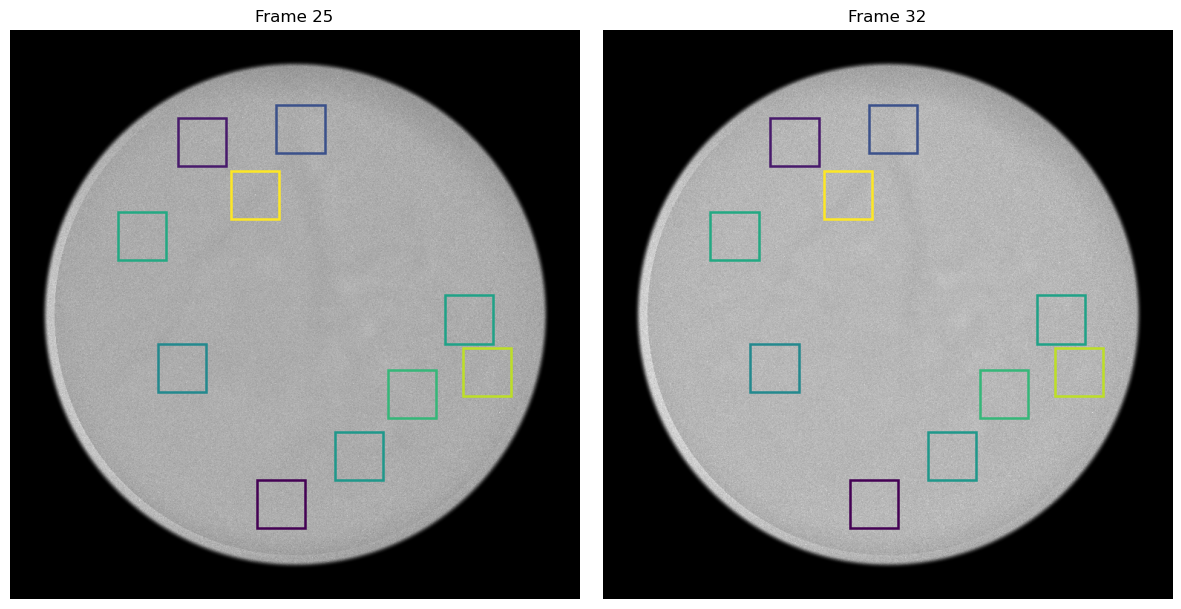

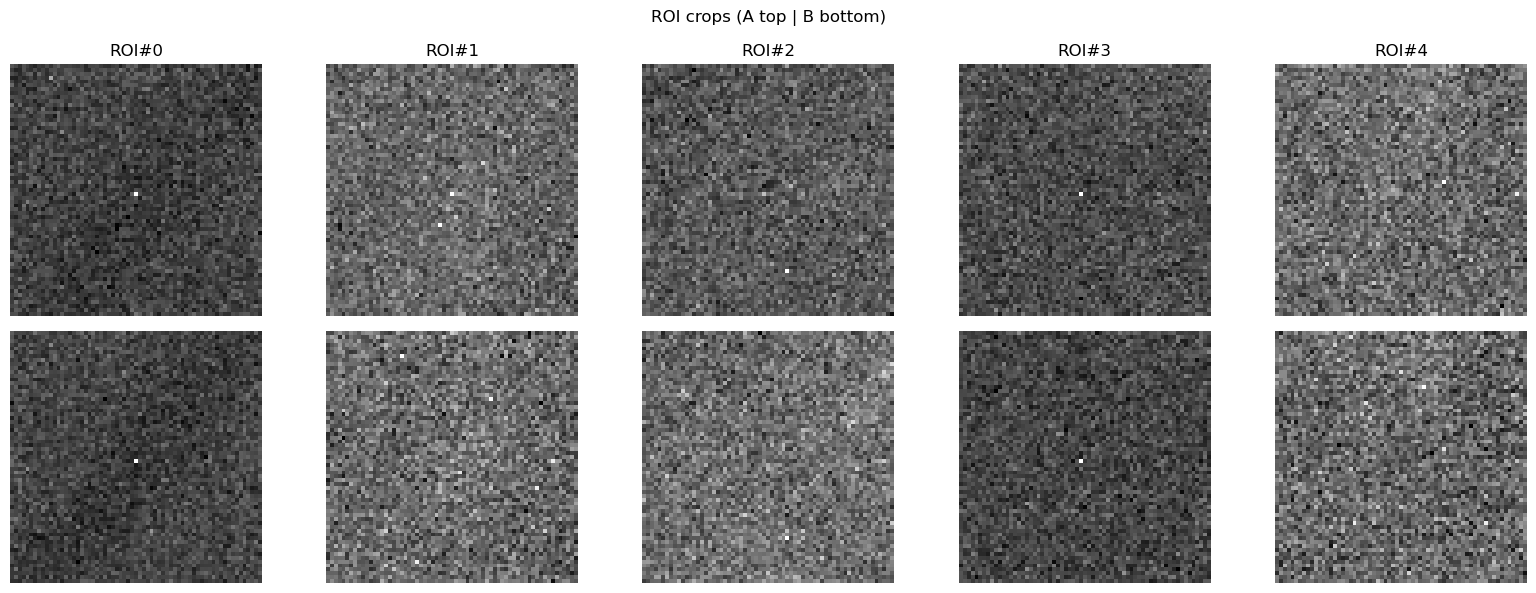

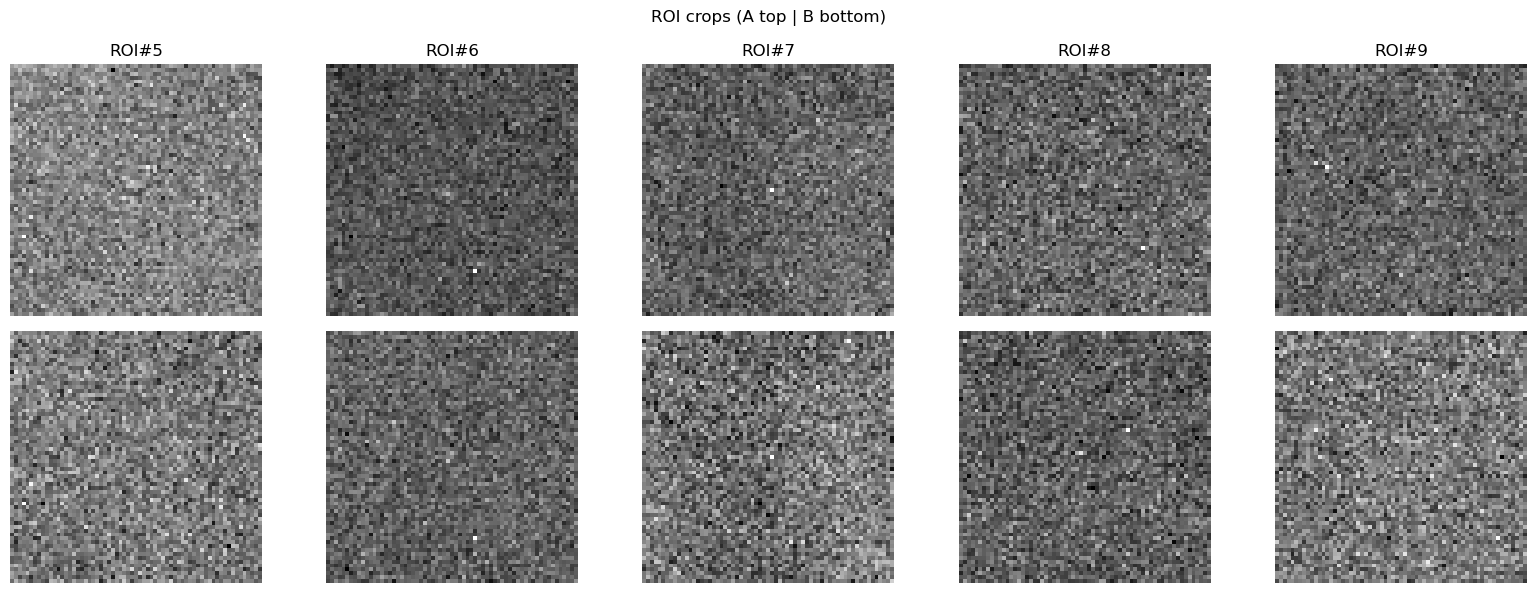

In [14]:
# входные кадры (например, movie[t0], movie[t1])
A = movie[25]
B = movie[32]

# маска (1 внутри диска, 0 снаружи). Если у тебя есть готовая — используй её.
# иначе можно прикинуть как круг по центру и радиусу или взять ту, что применяли ранее.
#mask = your_mask  # HxW, float32/uint8

# подбираем ROI
centers, S, valid_core, parts = select_rois(
    frame_ref=A, mask=mask, K=10, hw=32, search=6, margin=12,
    sigma_smooth=1.0, std_win=11,
    w_grad=0.4, w_corner=0.4, w_std=0.2, min_distance_factor=2.0
)

# считаем качество (и dy,dx,theta) для каждого ROI
rows = roi_quality(A, B, centers, hw=32, search=6)
scores = rows[:, -1]  # max(trans, rot)
# rows: [cy, cx, dy, dx, theta_deg, trans_peak, rot_peak, score]

# показываем на кадрах
plot_rois_on_frames(A, B, centers, hw=32, scores=scores,
                    titleA='Frame 25', titleB='Frame 32')

# показываем сами вырезки
plot_roi_crops(A, B, centers, hw=32, cols=5, suptitle='ROI crops (A top | B bottom)')


### ROI detection + translation detection + rotetion detection v_4

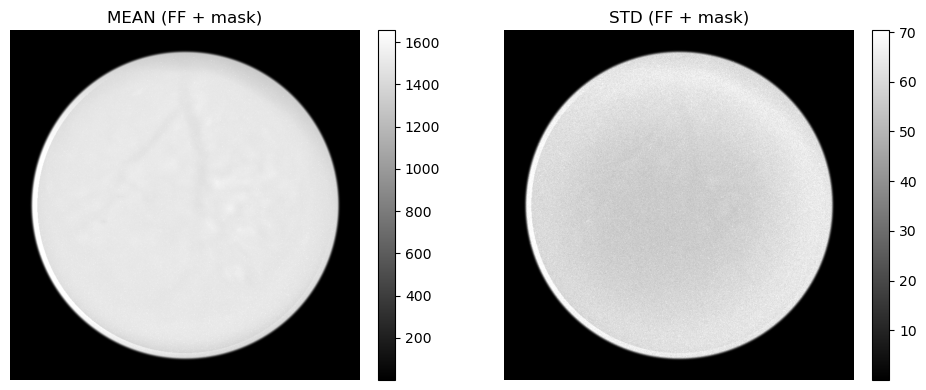

In [21]:
# --- LOAD (FF output) + SOFT MASK (r=0.9) exactly like CROP+MASK ---

from pathlib import Path
import numpy as np
import tifffile as tiff

def make_soft_disk_mask(h, w, r_frac=0.90, edge=12.0):
    cy = h // 2
    cx = w // 2
    yy, xx = np.ogrid[:h, :w]
    dist = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    r = int(r_frac * (h // 2))              # <-- 0.90 как в старом коде
    mask = np.ones((h, w), np.float32)
    mask[dist > r] = 0.0
    ring = (dist > r - edge) & (dist <= r)
    # мягкий косинусный край — тот же, что был ранее
    mask[ring] = 0.5 * (1.0 + np.cos(np.pi * (dist[ring] - (r - edge)) / edge))
    return mask

# 1) читаем стек после FF
in_path = Path("data/shorts/MoS1b_s3_C1_M3_T3_TRE_2025_04_08/MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125_crop768_masked_flatfield_reg.tiff")
arr = tiff.imread(in_path.as_posix())
movie = arr.astype(np.float32)
if movie.ndim == 3 and movie.shape[0] in (768, 800):  # (H,W,T) -> (T,H,W)
    movie = np.transpose(movie, (2,0,1)).astype(np.float32)

T, H, W = movie.shape
mask = make_soft_disk_mask(H, W, r_frac=0.90, edge=12.0)

# 2) применяем маску (как раньше)
movie_masked = movie * mask[None, ...]

# (опционально) быстрые шкалы, чтобы визуализация совпадала с «красивой»
mean_map = movie_masked.mean(axis=0)
std_map  = movie_masked.std(axis=0, ddof=1)

vmean = (float(np.percentile(mean_map[mask>0], 1)),
         float(np.percentile(mean_map[mask>0], 99)))
vstd  = (float(np.percentile(std_map[mask>0],  1)),
         float(np.percentile(std_map[mask>0],  99)))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,4))
im0 = ax[0].imshow(mean_map, cmap="gray", vmin=vmean[0], vmax=vmean[1]); ax[0].set_title("MEAN (FF + mask)"); ax[0].axis("off"); fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
im1 = ax[1].imshow(std_map,  cmap="gray", vmin=vstd[0],  vmax=vstd[1]);  ax[1].set_title("STD (FF + mask)");  ax[1].axis("off"); fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


In [29]:
# === Viz utils: перцентильные шкалы внутри маски (как в FF-QC) ===
import numpy as np
import matplotlib.pyplot as plt

def _mask_core(mask, core_thresh=0.99):
    """Возвращает булеву маску ядра (core), где маска почти 1."""
    if mask is None:
        return None
    m = np.asarray(mask, dtype=np.float32)
    return (m > core_thresh)

def robust_limits_masked(img, mask=None, p=(1, 99), core_thresh=0.99):
    """
    Перцентильные лимиты vmin/vmax, как в FF-QC:
    считаем только по пикселям внутри 'ядра' маски.
    """
    img = np.asarray(img)
    if mask is None:
        x = img.ravel()
    else:
        core = _mask_core(mask, core_thresh)
        x = img[core].ravel()
    # защищаемся от NaN/Inf и вырожденности
    x = x[np.isfinite(x)]
    if x.size == 0:
        return float(np.nanmin(img)), float(np.nanmax(img))
    lo, hi = np.nanpercentile(x, p)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = float(np.nanmin(x)), float(np.nanmax(x) + 1.0)
        if hi <= lo:
            hi = lo + 1.0
    return float(lo), float(hi)

def imshow_masked(ax, img, mask=None, p=(1, 99), core_thresh=0.99, title=None, cmap='gray', add_cbar=False):
    """
    Отрисовка с лимитами по robust_limits_masked. Возвращает (vmin, vmax, im).
    """
    vmin, vmax = robust_limits_masked(img, mask, p=p, core_thresh=core_thresh)
    im = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_axis_off()
    if title:
        ax.set_title(title)
    if add_cbar:
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    return vmin, vmax, im

def qc_grid_mean_std_corr_pnr(mean_map, std_map, corr_map, pnr_map, mask,
                              p_mean=(1,99), p_std=(1,99), p_corr=(5,95), p_pnr=(5,99),
                              core_thresh=0.99, figsize=(11,9), suptitle=None):
    """
    Сетка из 4 карт с лимитами как в «хорошем» FF-QC.
    """
    fig, axs = plt.subplots(2, 2, figsize=figsize)

    imshow_masked(axs[0,0], mean_map, mask, p=p_mean, core_thresh=core_thresh,
                  title="MEAN", add_cbar=True)
    imshow_masked(axs[0,1], std_map,  mask, p=p_std,  core_thresh=core_thresh,
                  title="STD",  add_cbar=True)
    imshow_masked(axs[1,0], corr_map, mask, p=p_corr, core_thresh=core_thresh,
                  title="Correlation", add_cbar=True)
    imshow_masked(axs[1,1], pnr_map,  mask, p=p_pnr,  core_thresh=core_thresh,
                  title="PNR", add_cbar=True)

    if suptitle:
        plt.suptitle(suptitle, y=0.99)
    plt.tight_layout()
    return fig, axs

def summarize_qc_stats(mean_map, std_map, corr_map, pnr_map, mask, core_thresh=0.99):
    """
    Возвращает те же агрегаты, что ты писал в FF-QC: <mean>, <STD>, <CV>, median(corr), median(PNR).
    """
    core = _mask_core(mask, core_thresh)
    m = np.asarray(mean_map)[core]
    s = np.asarray(std_map)[core]
    c = np.asarray(corr_map)[core]
    p = np.asarray(pnr_map)[core]

    gm = float(np.nanmean(m))
    gs = float(np.nanmean(s))
    cv = float(np.nanmean(s / (m + 1e-9)))
    corr_med = float(np.nanmedian(c))
    pnr_med  = float(np.nanmedian(p))
    return gm, gs, cv, corr_med, pnr_med


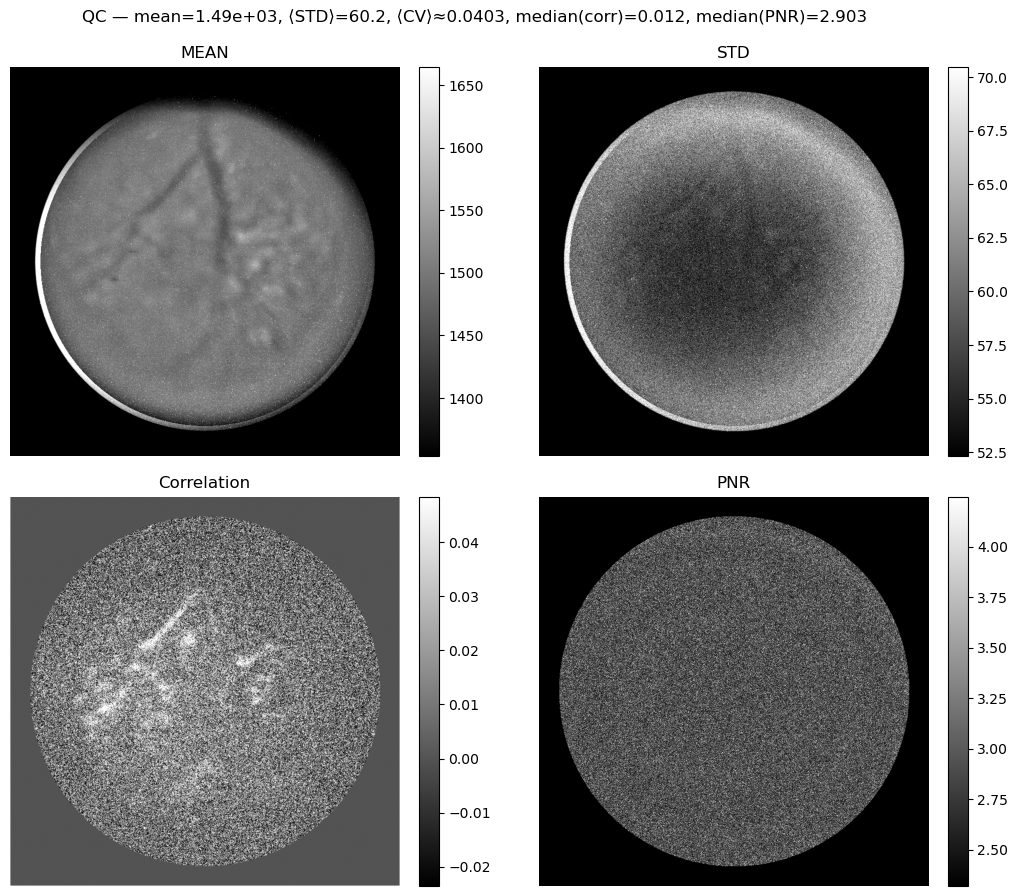

In [23]:
# === Проверка утилит на текущем стеке movie + mask ===
import numpy as np

# 1) карты
mean_map = movie.mean(axis=0).astype(np.float32)
std_map  = movie.std(axis=0, ddof=1).astype(np.float32)

# Если импортированы твои qc_maps:
#   from hybrid.summary.qc_maps import correlation_image, pnr_image
corr_map = correlation_image(movie, time_axis=0).astype(np.float32)
pnr_map  = pnr_image(movie, time_axis=0, hp_window=7).astype(np.float32)

# 2) сводные метрики «как в FF-QC»
gm, gs, cv, corr_med, pnr_med = summarize_qc_stats(mean_map, std_map, corr_map, pnr_map, mask, core_thresh=0.99)
title = f"QC — mean={gm:.3g}, ⟨STD⟩={gs:.3g}, ⟨CV⟩≈{cv:.3g}, median(corr)={corr_med:.3f}, median(PNR)={pnr_med:.3f}"

# 3) визуализация с перцентилями внутри ядра маски
_ = qc_grid_mean_std_corr_pnr(
    mean_map, std_map, corr_map, pnr_map, mask,
    p_mean=(1,99), p_std=(1,99), p_corr=(5,95), p_pnr=(5,99),
    core_thresh=0.99, figsize=(11,9), suptitle=title
)
plt.show()


In [30]:
# --- ROI visualization (uses existing imshow_masked) ---

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_rois_on_frames(A, B, centers, hw=32, scores=None,
                        titleA='Frame A', titleB='Frame B',
                        mask=None, p=(1,99), number_color='w', core_thresh=0.99):
    """
    Рисуем нумерованные ROI на двух кадрах. Отрисовка через imshow_masked().
    """
    import matplotlib.cm as cm
    cmap = plt.get_cmap('viridis')

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    imshow_masked(axes[0], A, mask=mask, p=p, core_thresh=core_thresh, title=titleA)
    imshow_masked(axes[1], B, mask=mask, p=p, core_thresh=core_thresh, title=titleB)

    if scores is None:
        vmin, vmax = 0.0, 1.0
    else:
        vmin, vmax = float(np.nanmin(scores)), float(np.nanmax(scores) + 1e-6)

    for idx, (cy, cx) in enumerate(centers):
        color = cmap(0.70) if scores is None else cmap((scores[idx]-vmin)/(vmax-vmin+1e-6))
        for ax in axes:
            ax.add_patch(Rectangle((cx - hw, cy - hw), 2*hw + 1, 2*hw + 1,
                                   fill=False, lw=1.8, color=color))
            ax.text(cx - hw + 3, cy - hw + 12, f"{idx}",
                    color=number_color, fontsize=9, weight='bold',
                    ha='left', va='center',
                    bbox=dict(facecolor='black', alpha=0.35, edgecolor='none', pad=1.5))
    plt.tight_layout(); plt.show()

def plot_roi_crops(A, B, centers, hw=32, cols=5,
                   suptitle='ROI crops (A top | B bottom)', p=(1,99), core_thresh=0.99):
    """
    Показываем вырезки ROI: верх — кадр A, низ — кадр B. Отрисовка через imshow_masked().
    """
    K = len(centers)
    cols = max(1, cols)
    pages = int(np.ceil(K / cols))
    for page in range(pages):
        idx = slice(page*cols, min((page+1)*cols, K))
        cs = centers[idx]
        fig, axes = plt.subplots(2, len(cs), figsize=(3.2*len(cs), 6))
        if len(cs) == 1:
            axes = np.array([[axes[0]], [axes[1]]])  # унификация

        for j, (cy, cx) in enumerate(cs):
            a = A[cy-hw:cy+hw+1, cx-hw:cx+hw+1]
            b = B[cy-hw:cy+hw+1, cx-hw:cx+hw+1]
            imshow_masked(axes[0, j], a, mask=None, p=p, core_thresh=core_thresh)
            axes[0, j].set_title(f"ROI#{page*cols + j}")
            imshow_masked(axes[1, j], b, mask=None, p=p, core_thresh=core_thresh)
        fig.suptitle(suptitle); plt.tight_layout(); plt.show()


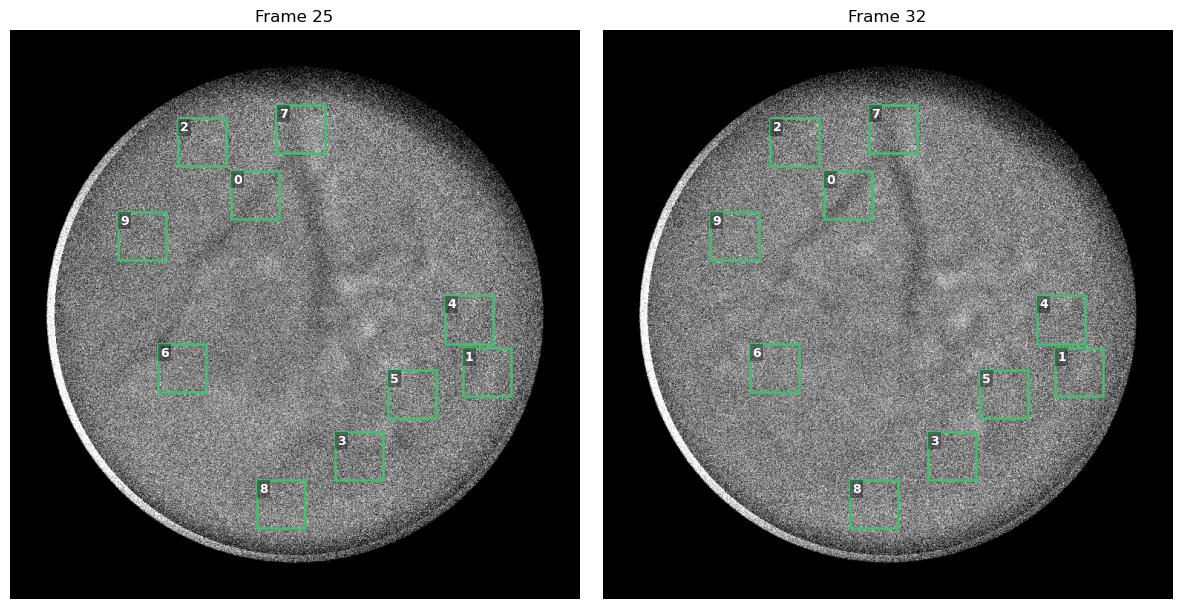

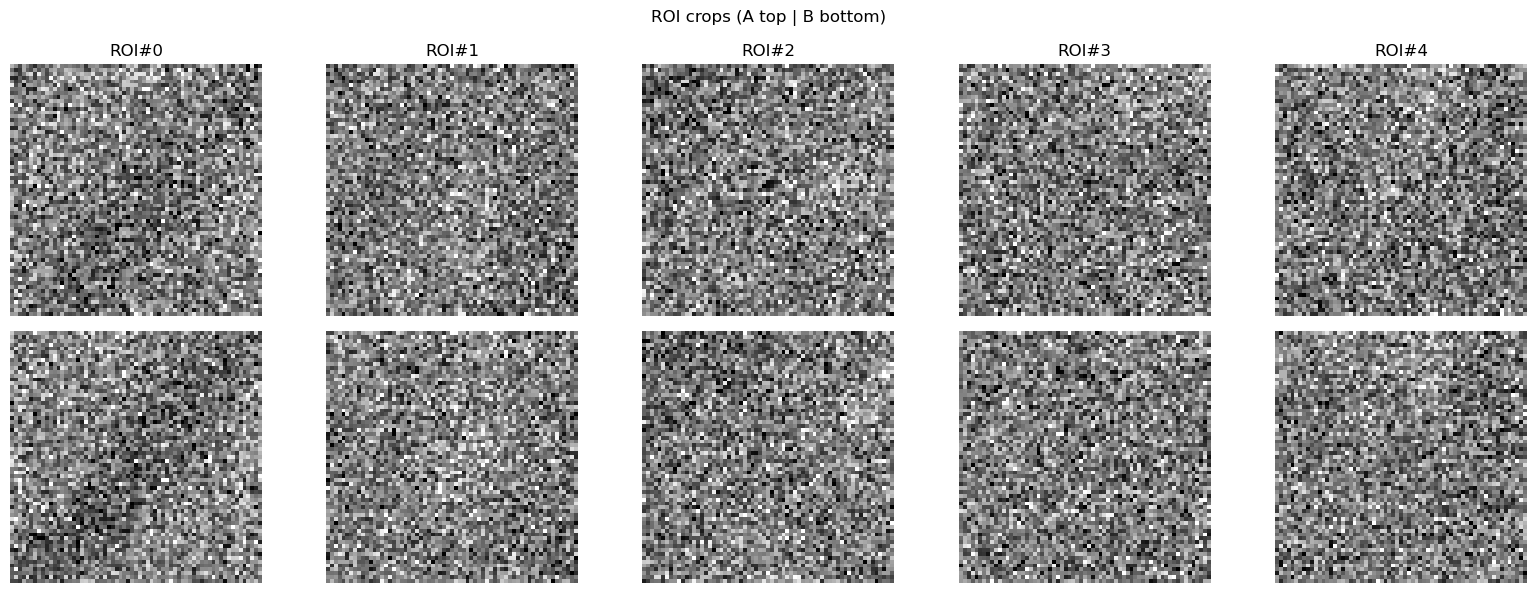

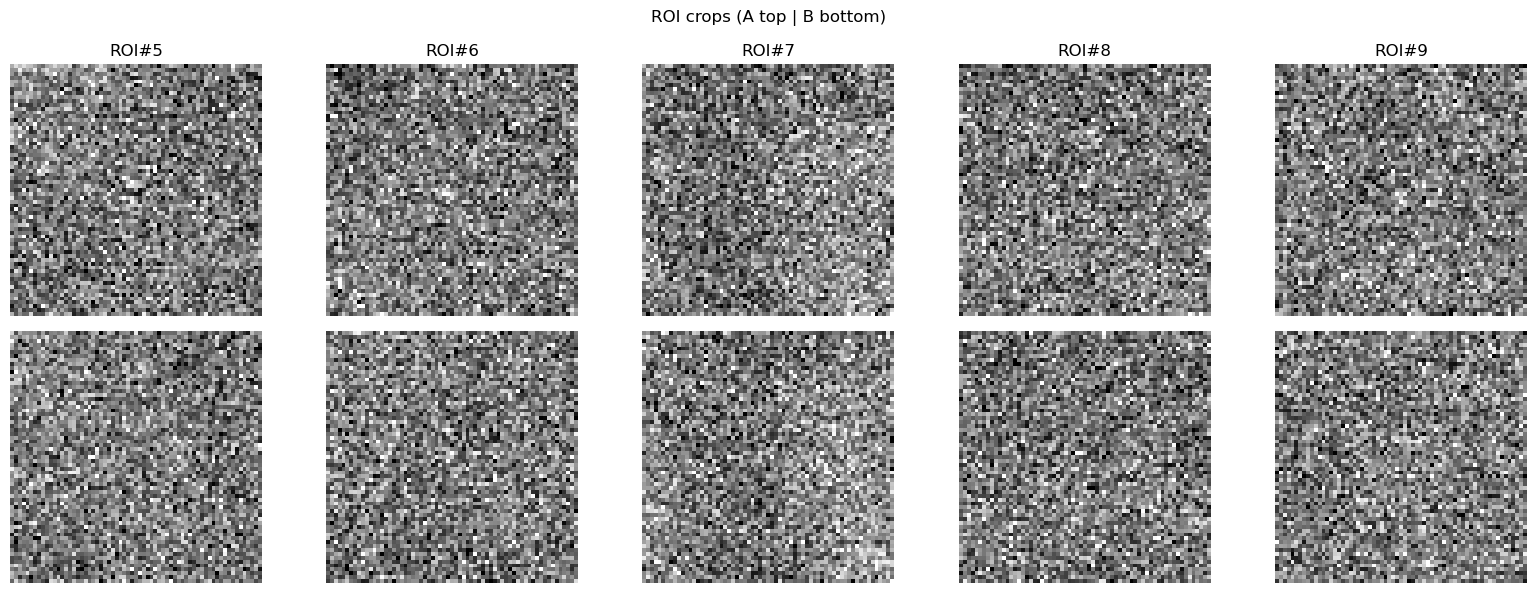

In [32]:
A = movie[25]; B = movie[32]
centers, S, valid_core, parts = select_rois(A, mask, K=10, hw=32, search=6, margin=12)

plot_rois_on_frames(A, B, centers, hw=32, titleA="Frame 25", titleB="Frame 32",
                    mask=mask, p=(1,99), number_color='w')

plot_roi_crops(A, B, centers, hw=32, cols=5, suptitle="ROI crops (A top | B bottom)",
               p=(1,99))


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def roi_quality(A, B, centers, hw=32, search=6):
    rows = []
    for (cy, cx) in centers:
        dy, dx, theta_deg, s_t, s_r = estimate_shift_rot_roi(
            A, B, cy=cy, cx=cx, hw=hw, search=search,
            pre_smooth=1.0, theta_max=5.0, theta_step=0.5, use_window=True
        )
        score = max(s_t, s_r)
        rows.append((cy, cx, dy, dx, theta_deg, s_t, s_r, score))
    return np.array(rows, dtype=np.float32)

def plot_rois_on_frames(A, B, centers, hw=32, scores=None, titleA='Frame A', titleB='Frame B', mask=None):
    cmap = plt.colormaps['viridis']  # без deprecated get_cmap
    vmin, vmax = robust_limits(A, mask, p=(1,99))  # одинаковые лимиты
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(A, cmap='gray', vmin=vmin, vmax=vmax); axes[0].set_axis_off(); axes[0].set_title(titleA)
    axes[1].imshow(B, cmap='gray', vmin=vmin, vmax=vmax); axes[1].set_axis_off(); axes[1].set_title(titleB)

    if scores is not None and len(scores) > 0:
        smin, smax = float(np.nanmin(scores)), float(np.nanmax(scores)+1e-9)
    else:
        smin, smax = 0.0, 1.0

    for i, (cy, cx) in enumerate(centers):
        color = 'lime' if scores is None else cmap((scores[i]-smin)/(smax-smin+1e-9))
        for ax in axes:
            ax.add_patch(Rectangle((cx-hw, cy-hw), 2*hw+1, 2*hw+1, fill=False, lw=1.8, color=color))
    plt.tight_layout(); plt.show()

def plot_roi_crops(A, B, centers, hw=32, cols=5, same_limits=True, mask=None, p=(1,99), suptitle='ROI crops (A top | B bottom)'):
    K = len(centers); rows = 2; cols = max(cols, 1)
    pages = int(np.ceil(K/cols))
    if same_limits:
        vminA, vmaxA = robust_limits(A, mask, p); vminB, vmaxB = robust_limits(B, mask, p)
    for pidx in range(pages):
        idx = slice(pidx*cols, min((pidx+1)*cols, K))
        cs = centers[idx]
        fig, axes = plt.subplots(rows, len(cs), figsize=(3.2*len(cs), 6))
        if len(cs) == 1: axes = np.array([[axes[0]],[axes[1]]])
        for j, (cy,cx) in enumerate(cs):
            a = A[cy-hw:cy+hw+1, cx-hw:cx+hw+1]
            b = B[cy-hw:cy+hw+1, cx-hw:cx+hw+1]
            if same_limits:
                axes[0, j].imshow(a, cmap='gray', vmin=vminA, vmax=vmaxA)
                axes[1, j].imshow(b, cmap='gray', vmin=vminB, vmax=vmaxB)
            else:
                vmin, vmax = robust_limits(a, None, p); axes[0, j].imshow(a, cmap='gray', vmin=vmin, vmax=vmax)
                vmin, vmax = robust_limits(b, None, p); axes[1, j].imshow(b, cmap='gray', vmin=vmin, vmax=vmax)
            axes[0, j].set_axis_off(); axes[1, j].set_axis_off()
            axes[0, j].set_title(f"ROI#{pidx*cols+j}")
        fig.suptitle(suptitle); plt.tight_layout(); plt.show()


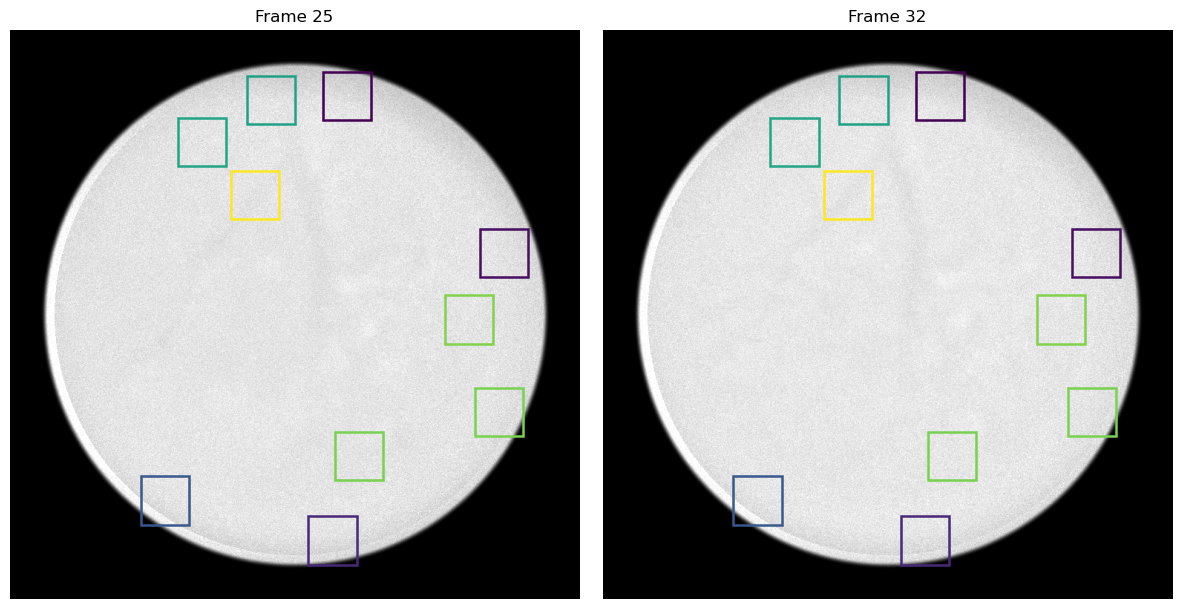

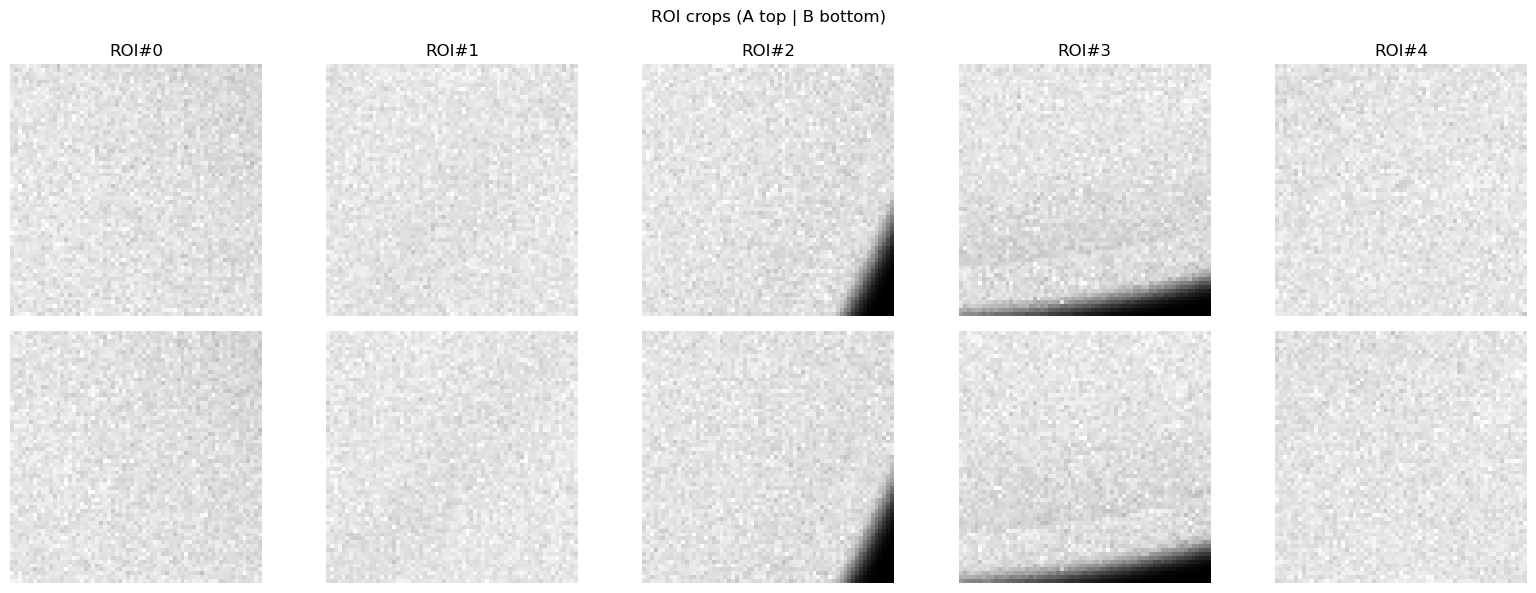

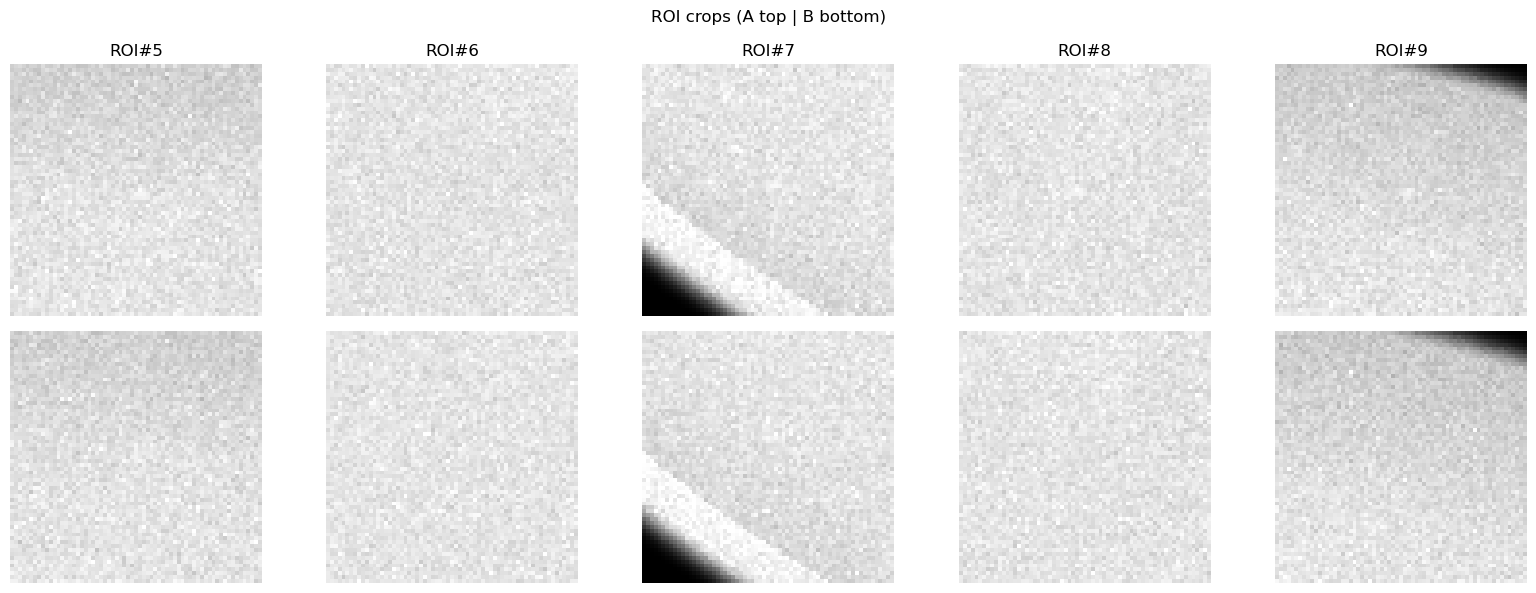

cy     cx        dy        dx  theta_deg  score_trans    score_rot  \
0  300.0  665.0 -6.500000 -1.068402   2.472222  2927.356689  4223.841309   
1  222.0  330.0  1.239561 -4.488789  -2.750000  1809.557739  4224.223633   
2  515.0  659.0  0.154066  0.087776   2.550000  4202.461426  4224.143066   
3  688.0  434.0 -0.001286  0.031323   2.218750  4208.894043  4223.873047   
4  151.0  258.0 -6.500000  3.118084  -4.000000  1050.429688  4224.060059   
5   94.0  351.0 -1.987387  4.175047   2.562500  3700.901611  4224.054688   
6  574.0  470.0 -6.500000  1.814841   5.000000   789.450012  4224.141602   
7  634.0  208.0  0.034533 -0.033112  -1.708333  4209.390625  4223.936035   
8  390.0  618.0 -0.230345 -0.526985   3.000000  1123.674072  4224.148926   
9   88.0  454.0  0.130400  0.569586  -2.527778  4187.998535  4223.826660   

         score  
0  4223.841309  
1  4224.223633  
2  4224.143066  
3  4223.873047  
4  4224.060059  
5  4224.054688  
6  4224.141602  
7  4223.936035  
8  4224.148926  
9  4223.826660

In [19]:
# выберем пару кадров — как ты сравнивал
A = movie[25]
B = movie[32]

# 1) подбор ROI (внутри маски, вдали от края)
centers, S, valid_core, parts = select_rois(
    frame_ref=A, mask=mask,
    K=10, hw=32, search=6, margin=12,
    sigma_smooth=1.0, std_win=11,
    w_grad=0.4, w_corner=0.4, w_std=0.2,
    min_distance_factor=2.0
)

# 2) оценка качества и векторов (dy,dx,θ)
rows = roi_quality(A, B, centers, hw=32, search=6)
scores = rows[:, -1]  # max(trans_peak, rot_peak)

# 3) кадры с одинаковым контрастом + рамки ROI
plot_rois_on_frames(A, B, centers, hw=32, scores=scores,
                    titleA='Frame 25', titleB='Frame 32', mask=mask)

# 4) сами кропы, тоже с одинаковыми лимитами (как в большом кадре)
plot_roi_crops(A, B, centers, hw=32, cols=5, same_limits=True, mask=mask, suptitle='ROI crops (A top | B bottom)')

# (опционально) быстрый вывод чисел:
import pandas as pd
df = pd.DataFrame(rows, columns=["cy","cx","dy","dx","theta_deg","score_trans","score_rot","score"])
df


[I/O] Using full-RAM imread (~0.66 GiB): D:\Projects\hybrid\notebooks\data\shorts\MoS1b_s3_C1_M3_T3_TRE_2025_04_08\MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125_crop768_masked_flatfield_reg.tiff
[GPU-auto] CuPy available → using GPU backend for pw-rigid
pw-rigid MC (GPU): 100%|████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 132.11it/s]
[OK] data\shorts\MoS1b_s3_C1_M3_T3_TRE_2025_04_08\MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125_crop768_masked_flatfield_reg.tiff -> data\shorts\MoS1b_s3_C1_M3_T3_TRE_2025_04_08\MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125_crop768_masked_flatfield_reg_pwrigid_f32.tiff | mean_corr_after=0.9995
Rigid MC stats: None
[I/O] Using memmap: D:\Projects\hybrid\notebooks\data\shorts\MoS1b_s3_C1_M3_T3_TRE_2025_04_08\MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125_crop768_masked_flatfield_reg_pwrigid_f32.tiff
[GPU-auto] CuPy available → using GPU backend for pw-rigid
pw-rigid MC (GPU): 100%|█████████████████

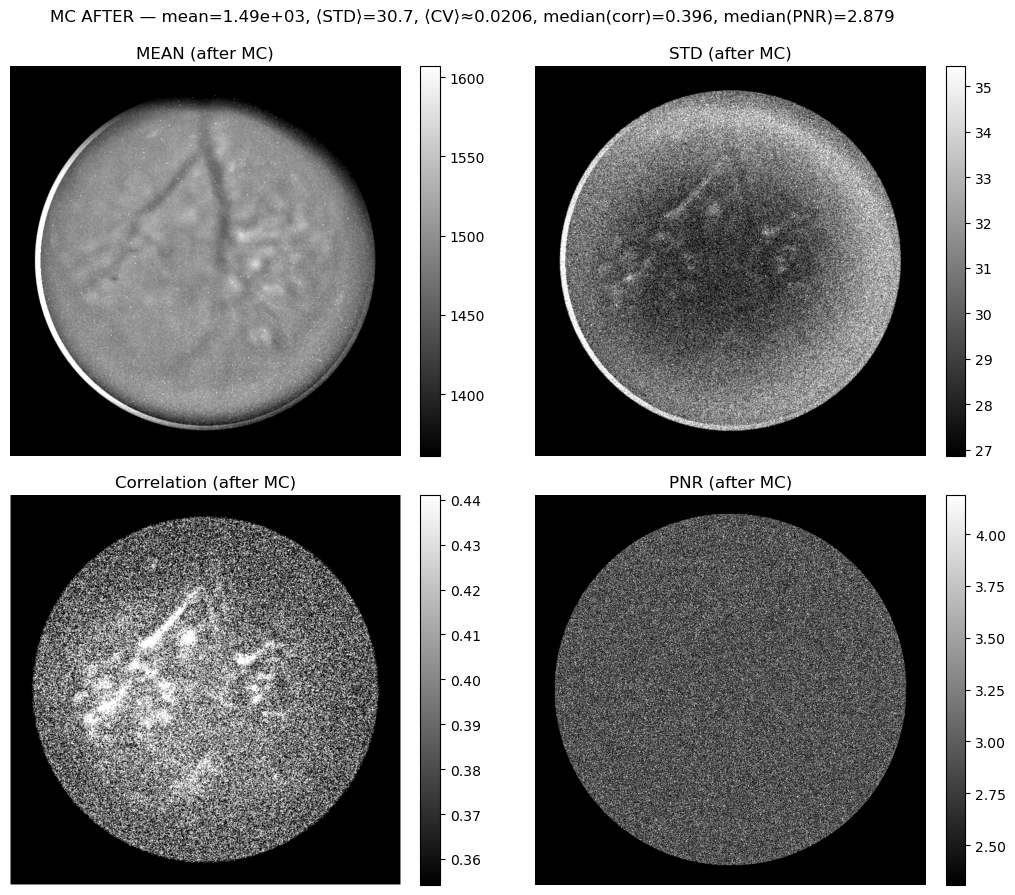

In [11]:
# --- MC on FF-reg: Rigid (1x1) -> PW-Rigid (3x3) + QC AFTER ---

from hybrid.cli.mc_cli import run_mc

# 0) вход: pre-MC flatfield (рег-версия, которую только что посчитали)
ff_reg_path = OUT_DIR / f"{BASENAME}_crop768_masked_flatfield_reg.tiff"
assert ff_reg_path.exists(), f"Не найден {ff_reg_path}"

# 1) Rigid pass (глобально). Это стабилизирует общий дрейф «пятна».
rigid_stats = run_mc(
    path=ff_reg_path,
    outdir=OUT_DIR,
    tiles=(1, 1),
    overlap=0,
    upsample=10,
    device="auto",
    stride=1,
    max_frames=0,
)
print("Rigid MC stats:", rigid_stats)

# ожидаемое имя выхода после 1-го прогона:
rigid_path = OUT_DIR / f"{BASENAME}_crop768_masked_flatfield_reg_pwrigid_f32.tiff"
assert rigid_path.exists(), f"Не найден результат rigid: {rigid_path}"

# 2) PW-rigid pass (локально) на результате rigid.
pwr_stats = run_mc(
    path=rigid_path,
    outdir=OUT_DIR,
    tiles=(3, 3),     # крупные плитки — устойчиво при малой текстуре
    overlap=64,
    upsample=10,
    device="auto",
    stride=1,
    max_frames=0,
)
print("PW-rigid MC stats:", pwr_stats)

# ожидаемое имя выхода после 2-го прогона:
mc_out = OUT_DIR / f"{BASENAME}_crop768_masked_flatfield_reg_pwrigid_f32.tiff"
assert mc_out.exists(), f"Не найден финальный MC: {mc_out}"

# 3) QC AFTER (внутри маски)
mc = read_tiff_stack(mc_out, method="auto", normalize_mode="none", verbose=False).astype(np.float32)

mean_after = mc.mean(axis=0)
std_after  = mc.std(axis=0, ddof=1)
corr_after = correlation_image(mc, time_axis=0)
pnr_after  = pnr_image(mc, time_axis=0, hp_window=7)

# шкалы и метрики считаем ТОЛЬКО внутри маски
core = mask > 0.99
vmean = (float(np.nanpercentile(mean_after[core], 1)),  float(np.nanpercentile(mean_after[core], 99)))
vstd  = (float(np.nanpercentile(std_after[core],  1)),  float(np.nanpercentile(std_after[core],  99)))
vcorr = (float(np.nanpercentile(corr_after[core], 5)),  float(np.nanpercentile(corr_after[core], 95)))
vpnr  = (float(np.nanpercentile(pnr_after[core],  5)),  float(np.nanpercentile(pnr_after[core],  99)))

fig, axs = plt.subplots(2, 2, figsize=(11, 9))
im0 = axs[0,0].imshow(mean_after, cmap="gray", vmin=vmean[0], vmax=vmean[1])
axs[0,0].set_title("MEAN (after MC)"); axs[0,0].axis("off"); fig.colorbar(im0, ax=axs[0,0], fraction=0.046, pad=0.04)
im1 = axs[0,1].imshow(std_after,  cmap="gray", vmin=vstd[0],  vmax=vstd[1])
axs[0,1].set_title("STD (after MC)");  axs[0,1].axis("off");  fig.colorbar(im1, ax=axs[0,1], fraction=0.046, pad=0.04)
im2 = axs[1,0].imshow(corr_after, cmap="gray", vmin=vcorr[0], vmax=vcorr[1])
axs[1,0].set_title("Correlation (after MC)"); axs[1,0].axis("off"); fig.colorbar(im2, ax=axs[1,0], fraction=0.046, pad=0.04)
im3 = axs[1,1].imshow(pnr_after,  cmap="gray", vmin=vpnr[0],  vmax=vpnr[1])
axs[1,1].set_title("PNR (after MC)"); axs[1,1].axis("off");  fig.colorbar(im3, ax=axs[1,1], fraction=0.046, pad=0.04)

gm = float(np.nanmean(mean_after[core])); gs = float(np.nanmean(std_after[core]))
cv = float(np.nanmean(std_after[core] / (mean_after[core] + 1e-9)))
corr_med = float(np.nanmedian(corr_after[core])); pnr_med = float(np.nanmedian(pnr_after[core]))
plt.suptitle(
    f"MC AFTER — mean={gm:.3g}, ⟨STD⟩={gs:.3g}, ⟨CV⟩≈{cv:.3g}, median(corr)={corr_med:.3f}, median(PNR)={pnr_med:.3f}",
    y=0.99
)
plt.tight_layout(); plt.savefig(OUT_DIR_QC / "mc_after_qc_grid_ffreg_rigid_then_pwr.png", dpi=200, bbox_inches="tight"); plt.show()
